# Car generator (GAN)

## Imports

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms, models
import torch.nn as nn
from torchvision.utils import save_image

import numpy as np

import random

import matplotlib.pyplot as plt

/home/arturo/PythonEnvs/mlenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Loading the dataset

In [3]:
transform = transforms.Compose([
    transforms.Resize(96),
    transforms.CenterCrop((96,128)),
    transforms.ToTensor()
])

dataset_train = datasets.ImageFolder('./dataset/train', transform=transform)
dataset_test = datasets.ImageFolder('./dataset/test', transform=transform)

whole_dataset = torch.utils.data.ConcatDataset([dataset_train, dataset_test])

In [4]:
def show_car(image):
    plt.imshow(image.permute(1,2,0))
    plt.xticks([])
    plt.yticks([])

In [5]:
batch_size = 32

data_loader = torch.utils.data.DataLoader(whole_dataset, batch_size=batch_size,shuffle=True)

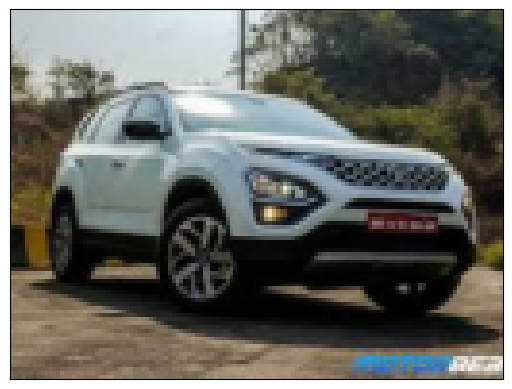

In [6]:
images, _ = next(iter(data_loader))

show_car(images[13])

In [7]:
images[13]

tensor([[[0.7373, 0.7451, 0.7490,  ..., 0.3255, 0.3176, 0.3176],
         [0.7373, 0.7451, 0.7451,  ..., 0.2784, 0.2784, 0.2784],
         [0.7333, 0.7412, 0.7412,  ..., 0.2824, 0.2902, 0.2980],
         ...,
         [0.4118, 0.4078, 0.4196,  ..., 0.8471, 0.9216, 0.8157],
         [0.4549, 0.4275, 0.4392,  ..., 0.6824, 0.6745, 0.6157],
         [0.4667, 0.4431, 0.4196,  ..., 0.5020, 0.5176, 0.5529]],

        [[0.7804, 0.7765, 0.7804,  ..., 0.3569, 0.3333, 0.3333],
         [0.7765, 0.7765, 0.7765,  ..., 0.3098, 0.2941, 0.2902],
         [0.7686, 0.7725, 0.7725,  ..., 0.3137, 0.3059, 0.3059],
         ...,
         [0.3490, 0.3490, 0.3608,  ..., 0.8235, 0.8980, 0.7882],
         [0.3922, 0.3686, 0.3804,  ..., 0.6392, 0.6235, 0.5686],
         [0.4039, 0.3843, 0.3608,  ..., 0.4431, 0.4549, 0.4863]],

        [[0.7804, 0.7882, 0.7922,  ..., 0.2549, 0.2510, 0.2627],
         [0.7804, 0.7882, 0.7882,  ..., 0.2157, 0.2118, 0.2157],
         [0.7804, 0.7843, 0.7843,  ..., 0.2235, 0.2235, 0.

In [8]:
latent_dim = 100
img_shape = (3, 96, 128)
n_epochs = 200

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Defining the model

In [28]:
#Hout​=(Hin​−1)×stride[0]−2×padding[0]+kernel_size[0]
#Wout​=(Win​−1)×stride[1]−2×padding[1]+kernel_size[1]

#Example:
#Image is 3x4
#Kernel is 3x4
#Stride is 2x2
#Padding is 1x1
#
#H = (3-1)*2 - 2*1 + 4 = 6
#W = (4-1)*2 - 2*1 + 4 = 8

#H = (6-1)*2 - 2*1 + 4 = 12
#W = (8-1)*2 - 2*1 + 4 = 16
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.leaky = nn.LeakyReLU(0.1)

        #INPUT: 100 x 1 x 1
        self.trans1 = nn.ConvTranspose2d(latent_dim, 256, kernel_size=(3,4), stride=(1,1), padding=(0,0), bias=False)
        self.bn1 = nn.BatchNorm2d(256)

        #INPUT: 256 x 3 x 4
        self.trans2 = nn.ConvTranspose2d(256, 128, kernel_size=(4,4), stride=(2,2), padding=(1,1), bias=False) 
        self.bn2 = nn.BatchNorm2d(128)

        #INPUT: 128 x 6 x 8
        self.trans3 = nn.ConvTranspose2d(128, 64, kernel_size=(4,4), stride=2, padding=1, bias=False) 
        self.bn3 = nn.BatchNorm2d(64)

        #INPUT: 64 x 12 x 16
        self.trans4 = nn.ConvTranspose2d(64, 32, kernel_size=(4,4), stride=2, padding=1, bias=False) 
        self.bn4 = nn.BatchNorm2d(32)
        
        #INPUT: 32 x 24 x 32
        self.trans5 = nn.ConvTranspose2d(32, 16, kernel_size=(4,4), stride=2, padding=1, bias=False) 
        self.bn5 = nn.BatchNorm2d(16)

        #INPUT: 16 x 48 x 64
        self.trans6 = nn.ConvTranspose2d(16, 3, kernel_size=(4,4), stride=2, padding=1, bias=False) 
        self.tanh = nn.Tanh() 

        #FINAL: 3 x 96 x 128

    def forward(self, z):
        z = self.trans1(z)
        z = self.bn1(z)
        z = self.leaky(z)

        z = self.trans2(z)
        z = self.bn2(z)
        z = self.leaky(z)

        z = self.trans3(z)
        z = self.bn3(z)
        z = self.leaky(z)
        
        z = self.trans4(z)
        z = self.bn4(z)
        z = self.leaky(z)

        z = self.trans5(z)
        z = self.bn5(z)
        z = self.leaky(z)

        z = self.trans6(z)
        z = self.tanh(z)
        
        return z.view(-1, *img_shape)

In [29]:
#Hout​=⌊(Hin​+2×padding[0]−kernel_size[0]​)/stride[0] + 1⌋

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.leaky = nn.LeakyReLU(0.1)

        #INPUT: 3 x 96 x 128
        self.conv1 = nn.Conv2d(3,32,kernel_size=4,stride=2,padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(32)

        #INPUT: 32 x 48 x 64
        self.conv2 = nn.Conv2d(32,64,kernel_size=4,stride=2,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(64)

        #INPUT: 64 x 24 x 32
        self.conv3 = nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False)
        self.bn3 = nn.BatchNorm2d(128)

        #INPUT: 128 x 12 x 16
        self.conv4 = nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False)
        self.bn4 = nn.BatchNorm2d(256)

        #INPUT: 256 x 6 x 8
        self.conv5 = nn.Conv2d(256,1,kernel_size=(6,8),stride=1,padding=0,bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        z = self.conv1(z)
        z = self.bn1(z)
        z = self.leaky(z)

        z = self.conv2(z)
        z = self.bn2(z)
        z = self.leaky(z)

        z = self.conv3(z)
        z = self.bn3(z)
        z = self.leaky(z)

        z = self.conv4(z)
        z = self.bn4(z)
        z = self.leaky(z)
        
        z = self.conv5(z)
        z = self.sigmoid(z)
        return z

In [34]:
generator = Generator().to(device)
generator.apply(weights_init)

discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

Discriminator(
  (leaky): LeakyReLU(negative_slope=0.1)
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 1, kernel_size=(6, 8), stride=(1, 1), bias=False)
  (sigmoid): Sigmoid()
)

In [35]:
lr = 1e-4
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5,0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5,0.999))

criterion = nn.BCELoss()

In [36]:
def createRealLabels(batch_size, percent):
    reals = torch.ones(batch_size, 1, 1, 1).to(device)

    for i in range(batch_size):
        if random.random() < percent:
            reals[i][0][0][0] = 0
        
    return reals

def createFakeLabels(batch_size, percent):
    reals = torch.zeros(batch_size, 1, 1, 1).to(device)

    for i in range(batch_size):
        if random.random() < percent:
            reals[i][0][0][0] = 1
        
    return reals

fixed_noise = torch.Tensor(np.random.normal(0, 1, (25, latent_dim)))
fixed_noise = torch.unsqueeze(fixed_noise,2)
fixed_noise = torch.unsqueeze(fixed_noise,3)
fixed_noise = fixed_noise.to(device)

In [37]:
for epoch in range(n_epochs):
    epoch_g_losses = []
    epoch_d_losses = []
    
    for i, (imgs, _) in enumerate(data_loader):
        # Create fake images

        z = torch.Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim)))
        z = torch.unsqueeze(z,2)
        z = torch.unsqueeze(z,3)
        z = z.to(device)
        
        fake_imgs = generator(z)
        
        # Discriminator training

        optimizer_D.zero_grad()

        percent = ((n_epochs - epoch)/n_epochs)*0.2
        imgs = imgs.to(device)
        #targets_real = torch.Tensor(np.random.uniform(0.95, 1.05, (imgs.size(0), 1, 1, 1))).to(device)
        targets_real = createRealLabels(imgs.size(0), percent).to(device)
        #targets_fake = torch.Tensor(np.random.uniform(0, 0.05, (imgs.size(0), 1, 1, 1))).to(device)
        targets_fake = createFakeLabels(imgs.size(0), percent).to(device)
        
        real_img_loss = criterion(discriminator(imgs), targets_real)
        fake_img_loss = criterion(discriminator(fake_imgs.detach()), targets_fake)

        real_img_loss.backward()
        fake_img_loss.backward()
        
        optimizer_D.step()

        epoch_d_losses.append(real_img_loss.item())
        epoch_d_losses.append(fake_img_loss.item())

        # Generator training
        
        optimizer_G.zero_grad()

        targets = torch.ones(imgs.size(0), 1, 1, 1)
        targets = targets.to(device)

        g_loss = criterion(discriminator(fake_imgs), targets)

        g_loss.backward()
        optimizer_G.step()

        epoch_g_losses.append(g_loss.item())

    print(
        f"[Epoch {epoch}/{n_epochs}] [G loss: {sum(epoch_g_losses)/len(epoch_g_losses)}] [D loss: {sum(epoch_d_losses)/len(epoch_d_losses)}]"
    )

    test_images = generator(fixed_noise)
    
    save_image(test_images.data[:25], f"./result/fake_{epoch}.png", nrow=5, normalize=True)

[Epoch 0/200] [G loss: 3.412401819047127] [D loss: 0.725048313926877]
[Epoch 1/200] [G loss: 4.393796873456649] [D loss: 0.7300628297429048]
[Epoch 2/200] [G loss: 4.001889252935657] [D loss: 0.7527976820942099]
[Epoch 3/200] [G loss: 3.0432577993123586] [D loss: 0.6818494498729706]
[Epoch 4/200] [G loss: 2.139702043233027] [D loss: 0.5938625645660262]
[Epoch 5/200] [G loss: 2.1765931279377173] [D loss: 0.6000154314150337]
[Epoch 6/200] [G loss: 2.1071405663290097] [D loss: 0.5788106777285802]
[Epoch 7/200] [G loss: 2.101422572863921] [D loss: 0.5648820624324201]
[Epoch 8/200] [G loss: 1.82647525536195] [D loss: 0.5631137993044526]
[Epoch 9/200] [G loss: 1.9988894694634067] [D loss: 0.5615500681500398]
[Epoch 10/200] [G loss: 2.0241950695751276] [D loss: 0.5387882600531323]
[Epoch 11/200] [G loss: 2.5117329327204754] [D loss: 0.5690860139732142]
[Epoch 12/200] [G loss: 2.67384212913404] [D loss: 0.6143945567025483]
[Epoch 13/200] [G loss: 2.3652317119008712] [D loss: 0.571774385357631]

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

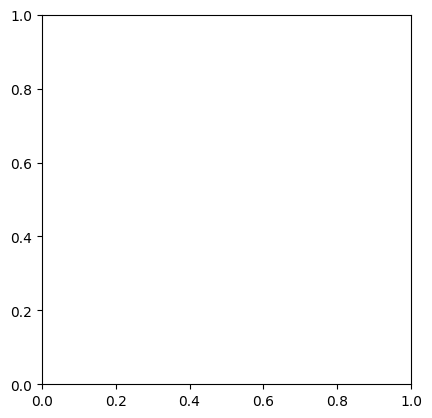

In [38]:
test_images = generator(fixed_noise)

show_car(test_images[13].det)